# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import warnings
warnings.filterwarnings("ignore")

#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']

# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)


In [2]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [3]:
df.shape #before dropping nulls

(32561, 15)

In [4]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [5]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [6]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [7]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

### Visualize the distribution of each feature

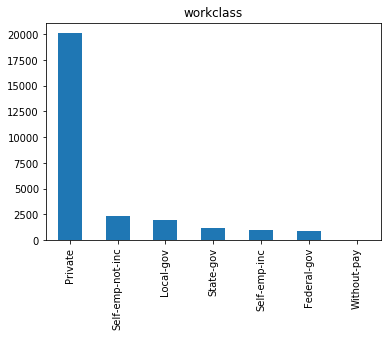

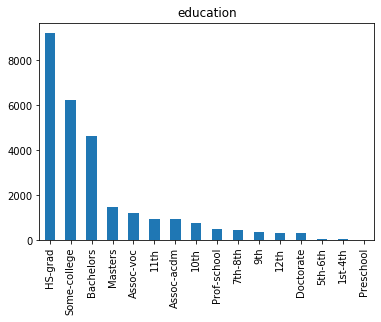

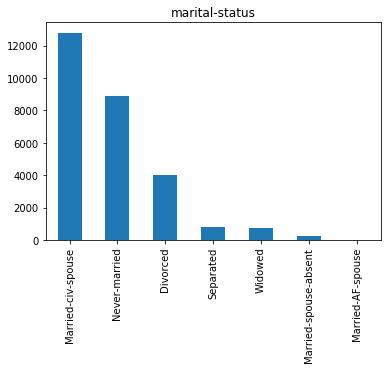

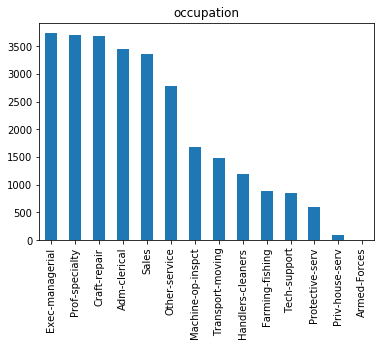

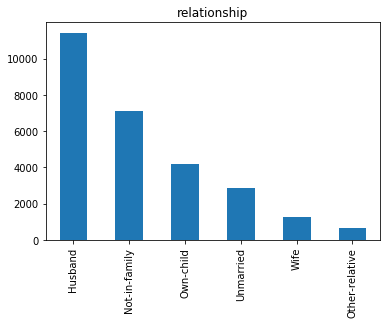

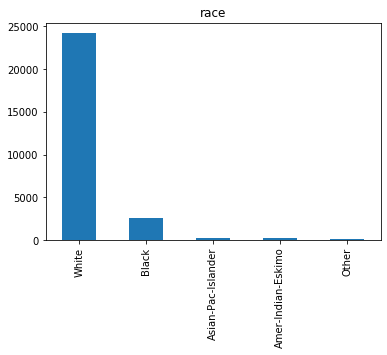

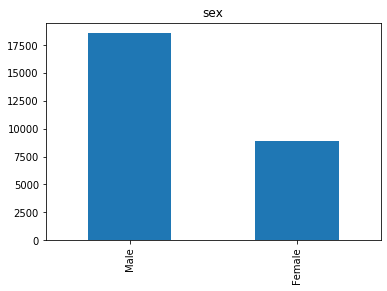

In [8]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

#print(string_columns)
for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

### One hot encode

In [9]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']
for i in one_hot_cols:
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))

In [10]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [11]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [12]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [13]:
new_df = new_df.reset_index()

In [14]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Get indexes for each individual feature

In [15]:
ranges = [[1,2],[3,4],[4,5],[5,6],[6,7],[7,14],[14,21],[21,35],[35,41],[41,46],[1,46]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Calculate accuracy per each feature

In [16]:
Y = np.array(new_df.iloc[:,46:47])
num_training = int(0.8*Y.shape[0])
sc = StandardScaler()
for i in range(len(ranges)):
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])
    
    X_train = X[:num_training]
    X_test = X[num_training:]
    Y_train = Y[:num_training]
    Y_test = Y[num_training:]
    
    clf = SVC(kernel = 'linear',gamma ='auto',random_state = 50)
    start_time = time.time()
    clf.fit(X_train, Y_train)
    scores = cross_val_score(clf, X_test, Y_test, cv=10)
    print(str(time.time() - start_time)+" seconds for SVM to train")
    print('Using' ,columns[i],
          'as a predictor for SVM we get accuracy of: ',max(scores))
    print()
    clf = MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2))
    start_time = time.time()
    clf.fit(X_train,Y_train)
    print(str(time.time() - start_time)+ " seconds for NN with relu to train")
    print('Using' ,columns[i],
          'as a predictor for a Neural Network with relu activation we get accuracy of: ',
          clf.score(X_test,Y_test))
    print()
    clf = MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2))
    start_time = time.time()
    clf.fit(X_train,Y_train)
    print(str(time.time() - start_time)+ " seconds for NN with logistic to train")
    print('Using' ,columns[i],
          'as a predictor for a Neural Network with logistic activation we get accuracy of: ',
          clf.score(X_test,Y_test))
    print()
    clf = MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2))
    start_time = time.time()
    clf.fit(X_train,Y_train)
    print(str(time.time() - start_time) + " seconds for NN with tanh to train")
    print('Using' ,columns[i],
          'as a predictor for a Neural Network with tanh activation we get accuracy of: ',
          clf.score(X_test,Y_test))
    print()
    print()
    print()

3.958221197128296 seconds for SVM to train
Using Age as a predictor for SVM we get accuracy of:  0.74

0.07770895957946777 seconds for NN with relu to train
Using Age as a predictor for a Neural Network with relu activation we get accuracy of:  0.7398654790038175

0.36975693702697754 seconds for NN with logistic to train
Using Age as a predictor for a Neural Network with logistic activation we get accuracy of:  0.7398654790038175

0.2975139617919922 seconds for NN with tanh to train
Using Age as a predictor for a Neural Network with tanh activation we get accuracy of:  0.7398654790038175



5.8119847774505615 seconds for SVM to train
Using Education as a predictor for SVM we get accuracy of:  0.74

0.5503277778625488 seconds for NN with relu to train
Using Education as a predictor for a Neural Network with relu activation we get accuracy of:  0.7613161243410289

0.2395460605621338 seconds for NN with logistic to train
Using Education as a predictor for a Neural Network with logistic ac